In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1194 - loss: 2.3458 - val_accuracy: 0.2143 - val_loss: 2.1243
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2069 - loss: 2.1607 - val_accuracy: 0.4048 - val_loss: 1.9809
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2019 - loss: 2.0423 - val_accuracy: 0.4048 - val_loss: 1.8822
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3352 - loss: 1.9447 - val_accuracy: 0.3810 - val_loss: 1.8203
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3120 - loss: 1.8594 - val_accuracy: 0.3810 - val_loss: 1.7670
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2182 - loss: 1

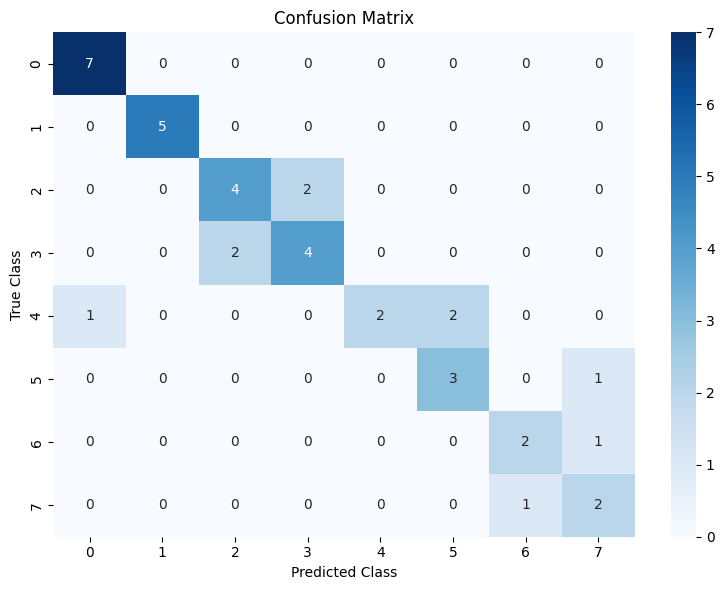

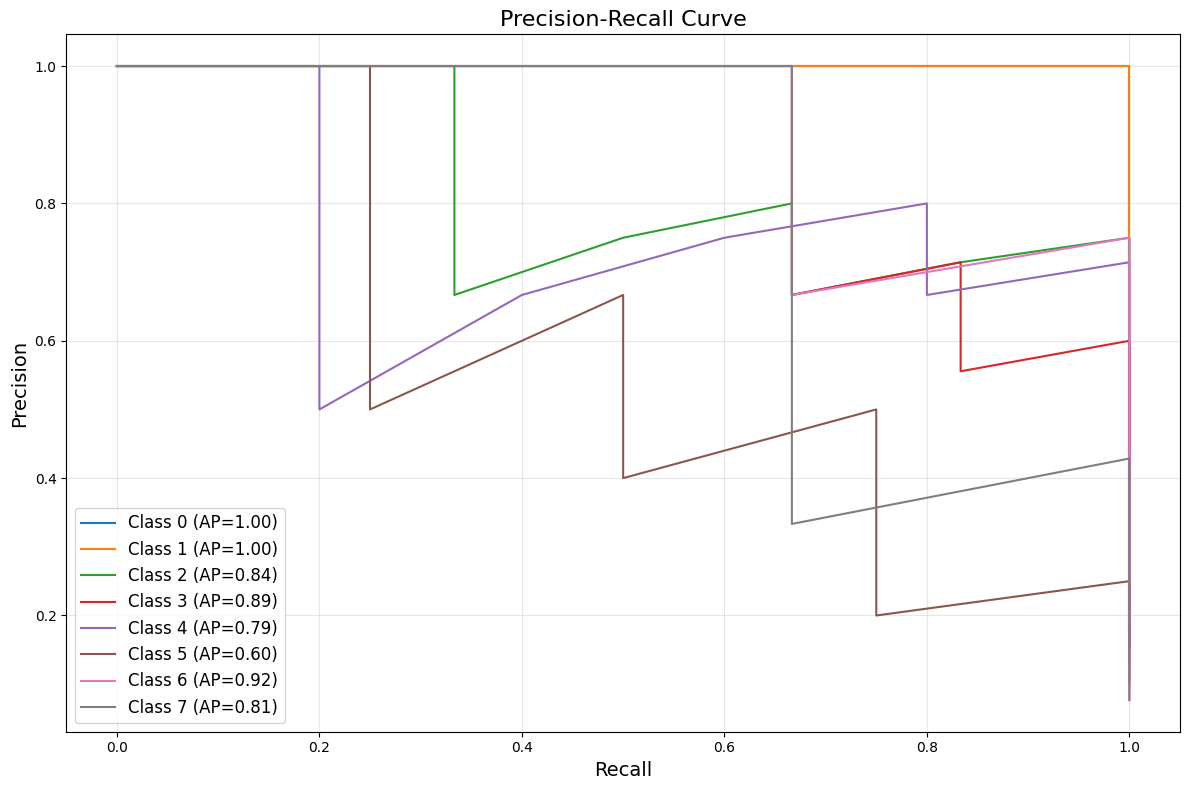


Overall PR AUC (Macro Average): 0.85


In [2]:
# Define a seed for reproducibility
seed = 12 

# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=seed) 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# One-hot encode the target variable
y_train_resampled_encoded = to_categorical(y_train_resampled, num_classes=len(np.unique(y)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y)))

# Define the model
def create_model():
    model = Sequential([
        Input(shape=(X_train_resampled.shape[1],)),
        Dense(128),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.5),
        Dense(64),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.5),
        Dense(len(np.unique(y)), activation='softmax')  
    ])
    model.compile(
        optimizer=SGD(learning_rate=0.001, momentum=0.8),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model instance
model = create_model()

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled_encoded,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# Print test results
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test_encoded.argmax(axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Precision-Recall Curve and PR AUC
# Binarize the true labels (One-vs-Rest approach for multi-class PR Curve)
y_test_binarized = label_binarize(y_true_classes, classes=np.unique(y))
y_pred_probabilities = y_pred  # Probabilities from the softmax layer

# Initialize PR Curve plot
plt.figure(figsize=(12, 8))

# Loop through each class to calculate PR Curve and AUC
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probabilities[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_probabilities[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP={auc_score:.2f})')

# Plot settings
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate Macro Average PR AUC
overall_pr_auc = average_precision_score(y_test_binarized, y_pred_probabilities, average="macro")
print(f"\nOverall PR AUC (Macro Average): {overall_pr_auc:.2f}") 


C:\Users\licop\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/39 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\licop\AppData\Local\Temp\ipykernel_23972\3620521389.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Mean SHAP Value', y='Feature', palette='viridis')


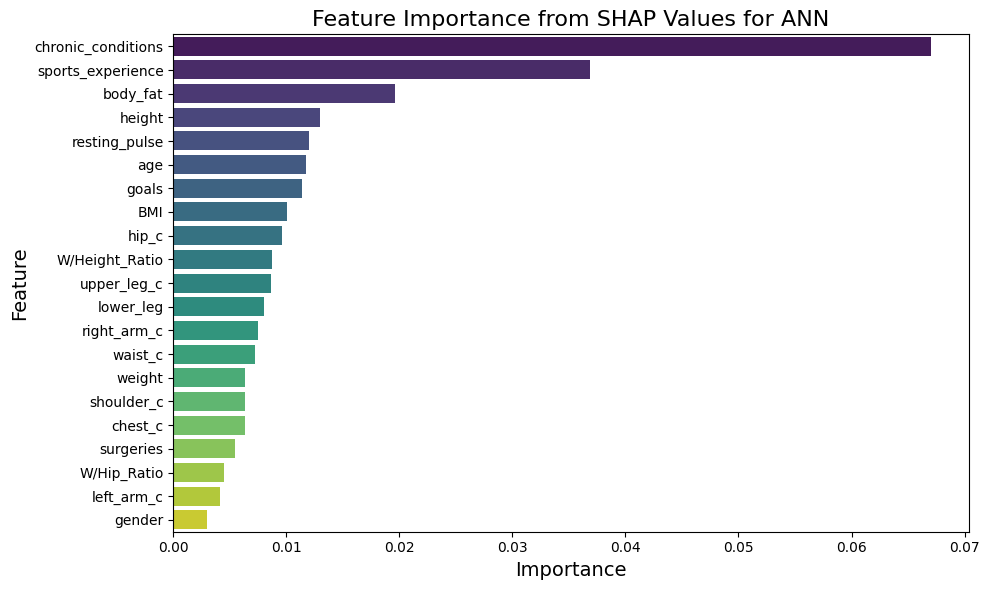

In [3]:
# Calculating feature importances using SHAP values
# Summarizing the data using K-Means (e.g., grouping into 50 clusters)
background_data = shap.kmeans(X_train_resampled, 50)

# Calculating SHAP values
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

# Combining SHAP values across classes (taking the mean of absolute values)
shap_values_combined = np.mean(np.abs(shap_values), axis=2)  # Average across classes (8)
shap_values_mean = np.mean(shap_values_combined, axis=0)  # Average across features

feature_importance = pd.DataFrame({
    'Feature': VT.drop(columns=["Training_Program"]).columns,
    'Mean SHAP Value': shap_values_mean
}).sort_values(by='Mean SHAP Value', ascending=False)

print(feature_importance)

# Plot the feature importances using SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Mean SHAP Value', y='Feature', palette='viridis')
plt.title('Feature Importance from SHAP Values for ANN', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()
